In [1]:
import pandas as pd
import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from lib.iux001 import fetch_data, aggregation_data
from lib.aux001 import calc_expression
from lib.cux001 import FactorEvaluate1

In [3]:
method = 'cicso0'
instruments = 'ims'
period = 15
datasets = ['train', 'val']

In [4]:
total_data = fetch_data(method=method,
                        instruments=instruments,
                        datasets=datasets)

./records/cicso0/ims/basic/train_data.feather
./records/cicso0/ims/basic/val_data.feather
./records/cicso0/ims/returns/train_returns.feather
./records/cicso0/ims/returns/val_returns.feather


In [5]:
total_data.head()

,trade_time,code,fz002_1_2_1,fz002_10_15_1,fz002_1_2_0,fz002_10_15_0,fz002_5_10_1,fz002_5_10_0,fz002_2_3_1,fz002_2_3_0,...,openint,vwap,nxt1_ret_1h,nxt1_ret_2h,nxt1_ret_3h,nxt1_ret_5h,nxt1_ret_10h,nxt1_ret_15h,time_weight,equal_weight
0,2022-07-25 09:56:00,IM,0.000005,-0.000010,-0.000046,5.249843e-06,-0.000017,-0.000004,0.000020,0.000086,...,16057.0,6961.466272,-0.000762,-0.001887,-0.001461,-0.001126,0.001574,-0.001524,-0.001253,-0.001370
1,2022-07-25 09:57:00,IM,0.000119,-0.000012,0.000062,2.844457e-06,-0.000017,-0.000001,0.000055,-0.000008,...,16059.0,6962.477215,-0.001126,-0.000700,-0.001026,-0.000791,0.002673,-0.000674,-0.000967,-0.000951
2,2022-07-25 09:58:00,IM,0.000040,-0.000015,0.000062,6.432116e-07,-0.000026,-0.000002,-0.000127,-0.000027,...,16045.0,6957.176389,0.000426,0.000099,0.000761,0.001459,0.003096,0.000201,0.000373,0.000429
3,2022-07-25 09:59:00,IM,0.000013,-0.000022,0.000000,-1.830461e-06,-0.000048,-0.000008,-0.000115,-0.000072,...,16048.0,6949.349133,-0.000327,0.000335,-0.000091,0.001500,0.001436,-0.000309,-0.000067,-0.000028
4,2022-07-25 10:00:00,IM,0.000601,-0.000022,0.000334,-3.198724e-06,-0.000041,-0.000007,0.000156,-0.000010,...,16046.0,6952.310870,0.000662,0.000236,0.001359,0.002731,0.000366,0.000903,0.000636,0.000752


In [6]:
total_data.filter(regex="^nxt1").columns.to_list()
nxt1_columns = total_data.filter(regex="^nxt1").columns.to_list()
basic_columns = [
        'close', 'high', 'low', 'open', 'value', 'volume', 'openint'
    ]

regex_pattern = r'^[^_]+_(5|10|15)_.*'
not_columns = total_data.columns[total_data.columns.str.contains(
        regex_pattern)]

factor_columns = [
        col for col in total_data.columns
        if col not in ['trade_time', 'code'] + nxt1_columns + basic_columns +
        not_columns.tolist()
    ]#[0:100]

In [ ]:
total_data = total_data[['trade_time', 'code'] + factor_columns + ["nxt1_ret_{}h".format(period)]]
total_data.head()

,trade_time,code,fz002_1_2_1,fz002_1_2_0,fz002_2_3_1,fz002_2_3_0,gd002_1_2_1,gd002_1_2_0,gd002_2_3_1,gd002_2_3_0,...,tf020_2_3_1,tf020_2_3_0,tf022_1_2_1,tf022_1_2_0,tf022_2_3_1,tf022_2_3_0,vwap,time_weight,equal_weight,nxt1_ret_15h
0,2022-07-25 09:56:00,IM,0.000005,-0.000046,0.000020,0.000086,0.965455,1.000000,0.845089,0.739744,...,4.850310e+07,4.851399e+07,6956.174543,6954.396369,6958.491758,6960.860870,6961.466272,-0.001253,-0.001370,-0.001524
1,2022-07-25 09:57:00,IM,0.000119,0.000062,0.000055,-0.000008,0.305566,0.516820,0.568212,0.808252,...,4.849829e+07,4.848961e+07,6959.796811,6961.130816,6959.175377,6956.619272,6962.477215,-0.000967,-0.000951,-0.000674
2,2022-07-25 09:58:00,IM,0.000040,0.000062,-0.000127,-0.000027,0.757937,0.476821,0.661996,0.640524,...,4.844099e+07,4.845412e+07,6954.444831,6955.091147,6954.836350,6956.250068,6957.176389,0.000373,0.000429,0.000201
3,2022-07-25 09:59:00,IM,0.000013,0.000000,-0.000115,-0.000072,0.927696,1.000000,0.798148,0.665956,...,4.838105e+07,4.838171e+07,6940.642715,6941.033284,6945.189608,6948.007853,6949.349133,-0.000067,-0.000028,-0.000309
4,2022-07-25 10:00:00,IM,0.000601,0.000334,0.000156,-0.000010,0.286532,0.484594,0.534688,0.650051,...,4.833793e+07,4.833372e+07,6944.897016,6945.162043,6944.070293,6942.792464,6952.310870,0.000636,0.000752,0.000903


In [ ]:
expression = "MCPS(4,MRes(2,'tn007_2_3_1','tc008_1_2_1'))"

In [27]:
factor_data = calc_expression(expression=expression,
                              total_data=total_data.set_index('trade_time'))

In [28]:
factor_data.head()

,trade_time,transformed,code
0,2022-07-25 09:57:00,-0.000230,IM
1,2022-07-25 09:58:00,0.000072,IM
2,2022-07-25 09:59:00,0.000863,IM
3,2022-07-25 10:00:00,-0.001164,IM
4,2022-07-25 10:01:00,-0.000863,IM


In [29]:
dt = aggregation_data(factor_data=factor_data,
                      returns_data=total_data,
                      period=period)

In [30]:
dt.tail()

,trade_time,transformed,code,nxt1_ret_15h
138064,2024-12-04 09:30:00,-0.000478,IM,-0.002012
138079,2024-12-04 09:45:00,0.000272,IM,-0.004210
138094,2024-12-04 10:00:00,-0.000595,IM,0.001020
138109,2024-12-04 10:15:00,-0.000401,IM,-0.003043
138124,2024-12-04 10:30:00,-0.000643,IM,0.000865


In [31]:
evaluate1 = FactorEvaluate1(factor_data=dt,
                                factor_name='transformed',
                                ret_name='nxt1_ret_{0}h'.format(period),
                                roll_win=240,
                                fee=0.000,
                                scale_method='roll_zscore',
                                expression=expression)

In [32]:
stats_dt = evaluate1.run()

In [33]:
stats_dt

{'total_ret': 0.5009002144502666,
 'avg_ret': 4.459593974802249e-05,
 'max_dd': -0.10472037588083949,
 'calmar': 4.783216353427122,
 'sharpe1': 0.029896050024124713,
 'sharpe2': 1.3864199396047872,
 'turnover': 0.28940305075918804,
 'win_rate': 0.507726038839006,
 'profit_ratio': 1.1639328629653907,
 'ic_mean': 0.04390152012550403,
 'ic_std': 0.08604624799861334,
 'ic_ir': 0.510208418689116,
 'factor_autocorr': -0.01611467774507313,
 'ret_autocorr': 0.038142472185576703}

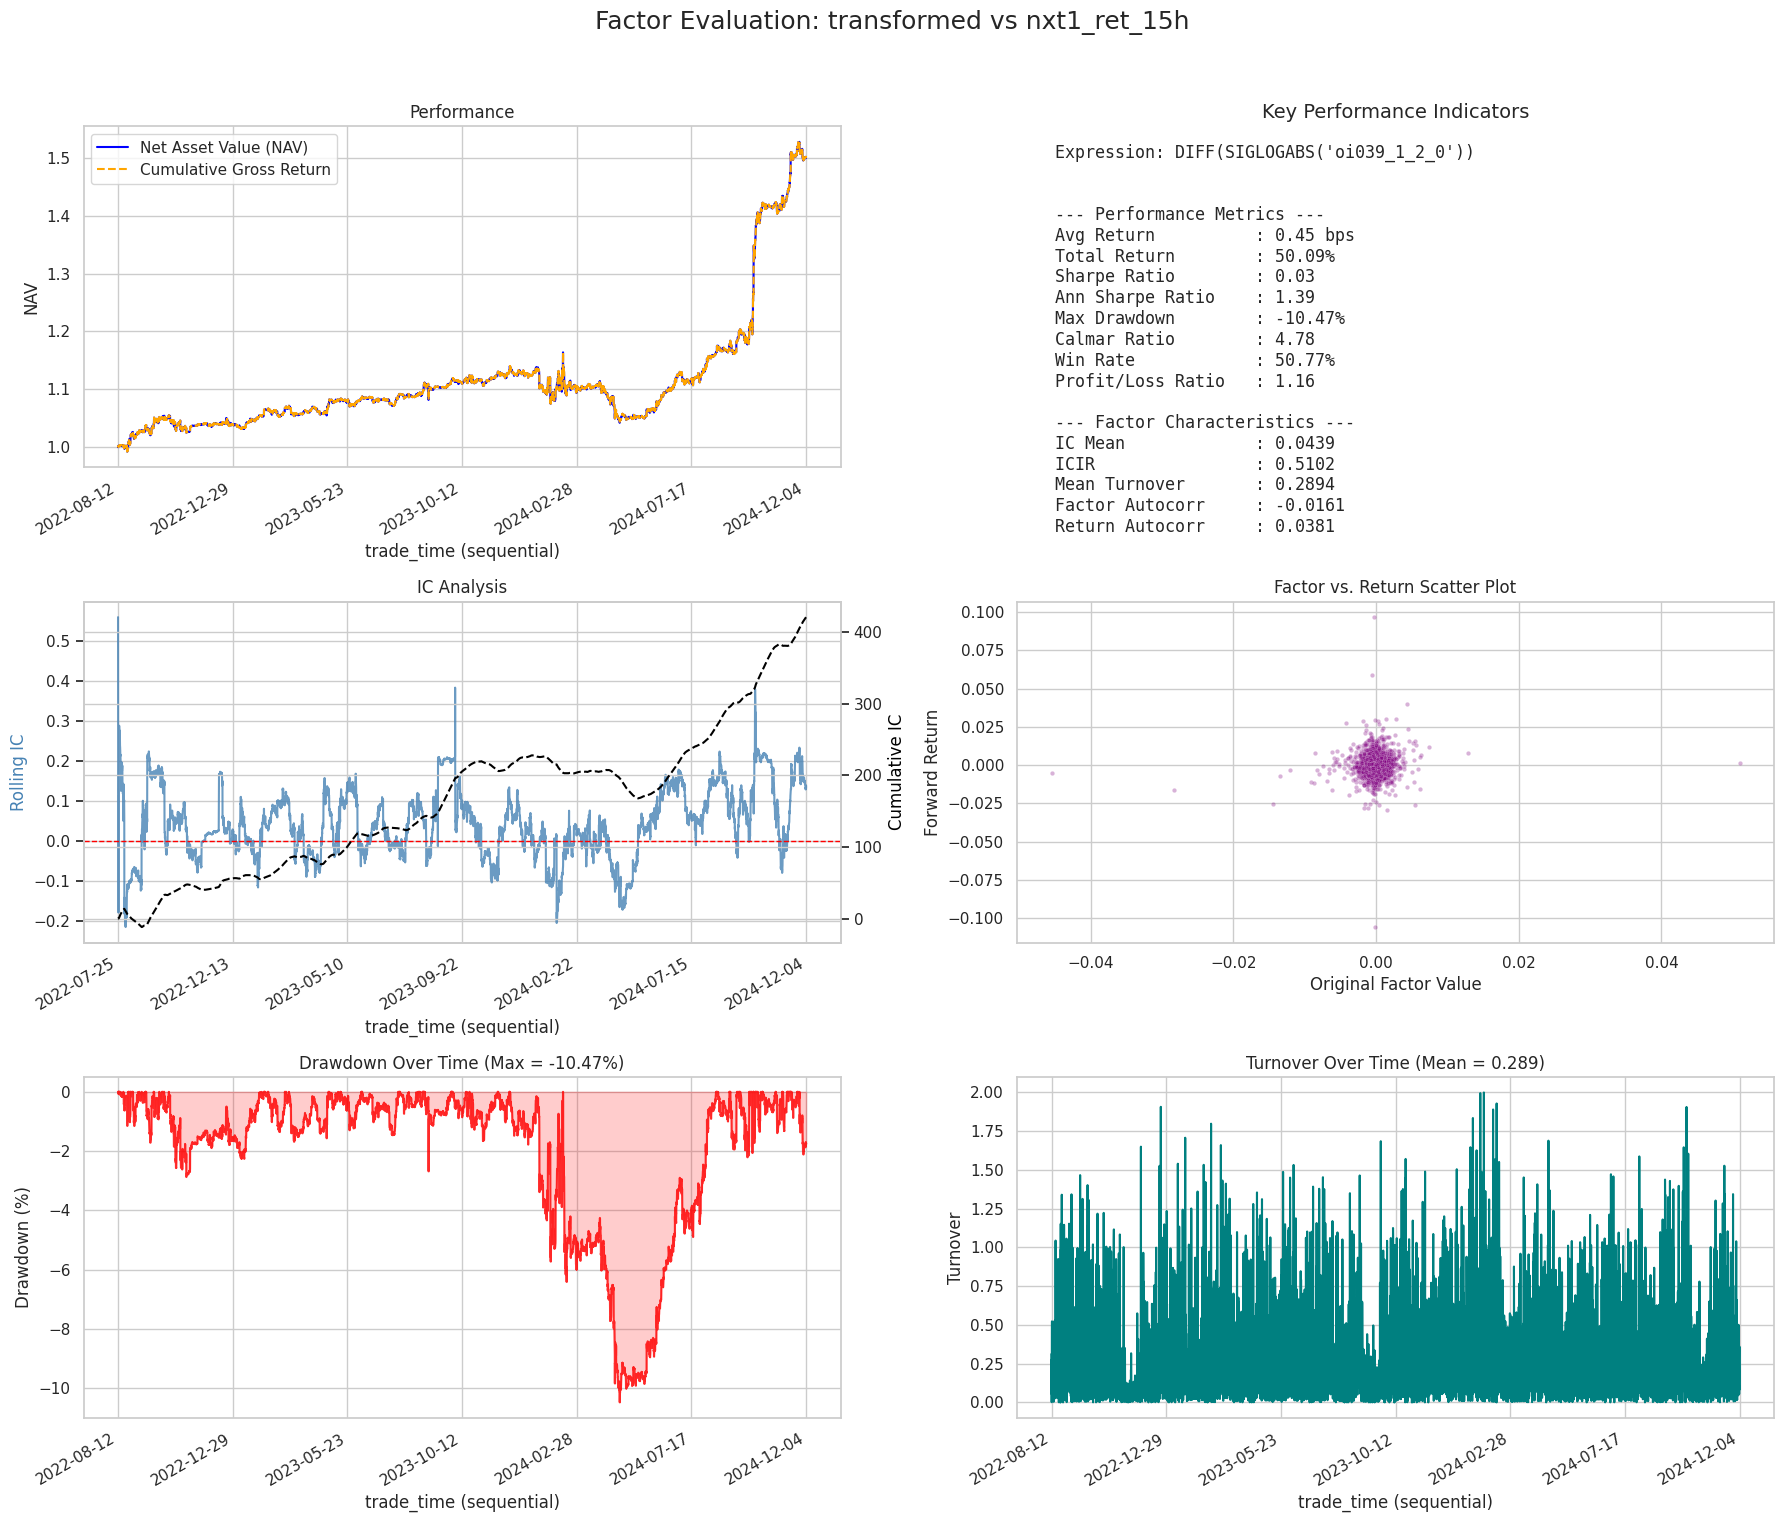

In [34]:
evaluate1.plot_results()